# HIPAA-compliant de-identification for DICOM files

HIPAA provides two methods for de-identification: the "Safe Harbor" method and the "Expert Determination" method. The Safe Harbor method is more straightforward and involves anonymizing/redacting 18 specific types of identifiers from the data.

Here, we will focus on the Safe Harbor method, which includes removing or redacting identifiers such as names, geographic subdivisions smaller than a state, dates directly related to an individual, phone numbers, email addresses, and more.

After de-ID,  the DICOM file will be updated and uploaded to destiny storage and evaluated by AWS services, Rekongnition, Comprehend and Comprehend Medical.

## Setup

Let's start by setting environment variables for de identification of DICOM file:
1) set local path of DICOM img folder.
2) set source and destiny s3 bucket.
3) set source and destiny prefix for DICOM file.
4) set user profile of AWS account if different default.

In [1]:
from med_img_de_id_class import ProcessMedImage
import yaml
# setup environment
LOC_DICOM_FOLDER = '../images/med_phi_img/'
LOC_DE_ID_DICOM_FOLDER = '../images/med_de_id_img/'
SOURCE_BUCKET = "crdcdh-test-submission"
DESTINATION_BUCKET = "crdc-hub-dev"
SOURCE_PREFIX = "dicom-images/"
DESTINATION_PREFIX = "de-id-dicom-images/"
EVAL_BUCKET = "crdc-hub-dev"
EVAL_PREFIX = "eval_de-id-dicom-images/"

processor = ProcessMedImage()


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/gup2/Library/Application Support/sagemaker/config.yaml
[(16, 16), (16, 32), (16, 48), (16, 48), (16, 4112), (16, 4128), (16, 4144), (16, 4160), (16, 4176), (16, 4192), (16, 4208), (16, 4096), (16, 4097), (16, 4240), (32, 13), (32, 16), (8, 32), (8, 48), (8, 144), (8, 80), (8, 4144), (8, 4168), (8, 4192), (32, 14), (32, 17), (8, 33), (8, 49), (8, 4158), (8, 112), (8, 128), (8, 4112), (8, 4160), (8, 4240), (24, 4096), (24, 4118), (24, 4096), (24, 4118), (24, 4120), (8, 24), (32, 82), (32, 512), (8, 129), (56, 16), (56, 97), (56, 768), (64, 1), (64, 2), (64, 3), (64, 6), (64, 16), (64, 4097), (64, 4098), (64, 8193), (8, 4228), (8, 4384), (16, 8624), (56, 64), (64, 577), (64, 578), (64, 579), (64, 580), (64, 581), (64, 595), (8, 42), (8, 34), (8, 35), (8, 36), (8, 37), (8, 38), (8, 39), (19, 4115), (8, 35

## Upload DICOM image(s) to s3 bucket

In [2]:
local_img_file = 'MartinChad-1-1.dcm'
local_img_path = LOC_DICOM_FOLDER + local_img_file
src_key= SOURCE_PREFIX + 'lung-1-1.dcm'
dist_key= DESTINATION_PREFIX + 'lung-1-1.dcm'
result, dicom_dataset, pixel_data = processor.upload_dicom_file(SOURCE_BUCKET, src_key, local_img_path)

DICOM file has been uploaded to the source a3 bucket.
DICOM pixel data has be saved to the source s3 bucket as png for de-identification.


## De-Identification in metadata of DICOM

In [3]:
processor.de_identify_dicom(dicom_dataset)

Tag: (0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation - Redacted Value: None
Tag: (0008, 0018) SOP Instance UID                    UI: 2.25.463628102274132074849128424375172598 - Redacted Value: None
Tag: (0008, 0020) Study Date                          DA: '20010705' - Redacted Value: None
Tag: (0008, 0021) Series Date                         DA: '20010705' - Redacted Value: None
Tag: (0008, 0022) Acquisition Date                    DA: '20010705' - Redacted Value: None
Tag: (0008, 0023) Content Date                        DA: '20010705' - Redacted Value: None
Tag: (0008, 0024) Overlay Date                        DA: '20010705' - Redacted Value: None
Tag: (0008, 0025) Curve Date                          DA: '20010705' - Redacted Value: None
Tag: (0008, 002a) Acquisition DateTime                DT: '20010705' - Redacted Value: None
Tag: (0008, 002a) Acquisition DateTime                DT: None - Redacted Value: None
Tag: (0008, 0030) S

## Draw DICOM image before de-identification

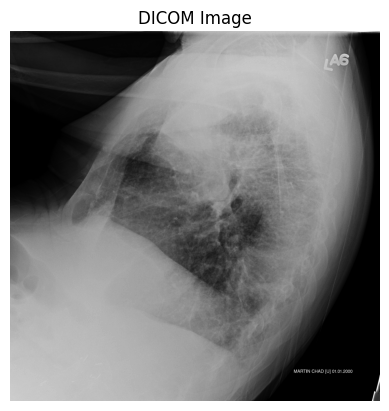

In [4]:
# show med image before de-identification
processor.draw_img(pixel_data)

## De-Identification in pixel of DICOM

Found text: LA6
Found text: MARTIN CHAD [U] 01.01.2000
Sensitive text detected in dicom-images/lung-1-1.png
[{'Text': 'MARTIN CHAD [U] 01.01.2000', 'Text Block': {'Width': 0.1591796875, 'Height': 0.013671875, 'Left': 0.7666015625, 'Top': 0.9130859375}}]
Showing redacted image


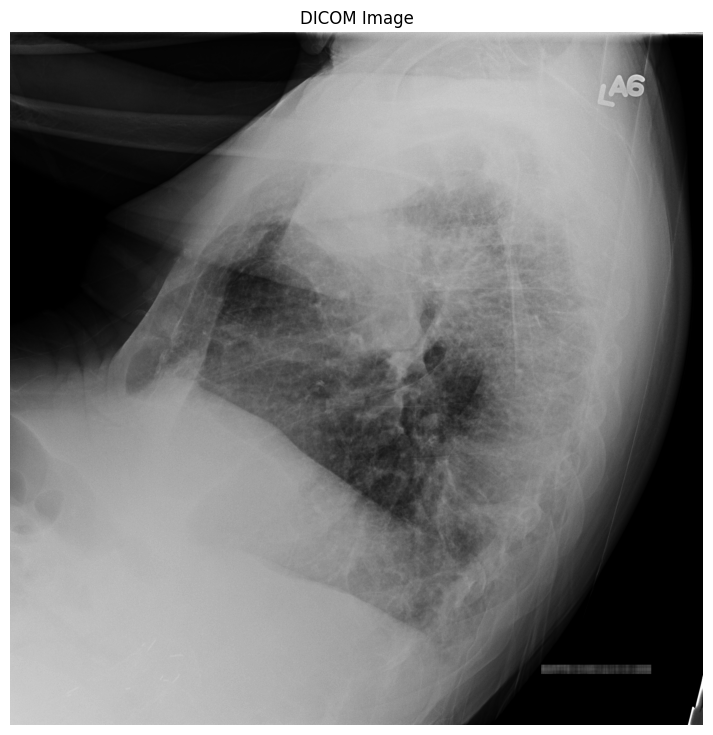

In [5]:
from PIL import Image
src_png_key = src_key.replace('.dcm', '.png')
local_de_id_png = LOC_DE_ID_DICOM_FOLDER + local_img_file.replace('.dcm', '.png')
id_text_detected = processor.detect_id_in_img(SOURCE_BUCKET, src_png_key)
if id_text_detected and len(id_text_detected):
    print(f'Sensitive text detected in {src_png_key}')
    print (id_text_detected)
    processor.redact_id_in_image(SOURCE_BUCKET, src_png_key, id_text_detected, local_de_id_png)
    # show redacted image
    print('Showing redacted image')
    img = Image.open(local_de_id_png)
    processor.draw_img(img)

else:
    print(f'No sensitive text detected in {src_png_key}')


## Updated the DICOM with redacted metadata and blurred sensitive identification text in image.

In [6]:
local_de_id_dicom = local_de_id_png.replace('.png', '.dcm')
if id_text_detected and len(id_text_detected):
    processor.convert_back_dicom(local_de_id_png, dicom_dataset,local_de_id_dicom)

DICOM file has been created and saved to ../images/med_de_id_img/MartinChad-1-1.dcm.


## Upload redacted DICOM to destination s3 bucket for evaluation with AWS Comprehend and Comprehend Medical

In [10]:
local_img_file = 'MartinChad-1-1.dcm'

# check after redacted
local_img_path = LOC_DE_ID_DICOM_FOLDER + local_img_file
src_key= DESTINATION_PREFIX + local_img_file
dist_key= EVAL_PREFIX + 'lung-1-1.dcm'
result, dicom_dataset, pixel_data = processor.upload_dicom_file(DESTINATION_BUCKET, src_key, local_img_path)

# check before redacted
# local_img_path = LOC_DICOM_FOLDER + local_img_file
# src_key= SOURCE_PREFIX + local_img_file
# dist_key= SOURCE_PREFIX + 'lung-1-1.dcm'
# result, dicom_dataset, pixel_data = processor.upload_dicom_file(SOURCE_BUCKET, src_key, local_img_path)

DICOM file has been uploaded to the source a3 bucket.
DICOM pixel data has be saved to the source s3 bucket as png for de-identification.


## Evaluate Redacted DICOM Metadata

In [11]:
tags, ids = processor.detect_id_in_tags(dicom_dataset)
if ids and len(ids) > 0:
    print("Found PII/PHI in redacted DICOM: ", ids)
else:
    print("No PII/PHI found in redacted DICOM")

No PII/PHI found in redacted DICOM


## Evaluate Redacted DICOM Pixel Data

In [12]:
from PIL import Image
src_png_key = src_key.replace('.dcm', '.png')
local_img_file = src_key.split('/')[-1]
# check after redacted
local_de_id_png = LOC_DE_ID_DICOM_FOLDER + local_img_file.replace('.dcm', '.png')
id_text_detected = processor.detect_id_in_img(DESTINATION_BUCKET, src_png_key, True)
# check before redacted
# local_de_id_png = LOC_DICOM_FOLDER + local_img_file.replace('.dcm', '.png')
# id_text_detected = processor.detect_id_in_img(SOURCE_BUCKET, src_png_key, True)
if id_text_detected and len(id_text_detected):
    print(f'Sensitive text detected in {src_png_key}')
    print (id_text_detected)
    processor.redact_id_in_image(SOURCE_BUCKET, src_png_key, id_text_detected, local_de_id_png)
    # show redacted image
    print('Showing redacted image')
    img = Image.open(local_de_id_png)
    processor.draw_img(img)

else:
    print(f'No sensitive text detected in {src_png_key}')

No sensitive text detected in de-id-dicom-images/MartinChad-1-1.png
